In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Homework part I: Prohibited Comment Classification (3 points)

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this notebook__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

In [26]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text)
print("after:", preprocess(text))

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [27]:
def tokenize_samples(array):
    for i in range(len(array)):
        array[i] = ' '.join(tokenizer.tokenize(array[i])).lower()

    return array

In [29]:
texts_train[0]

'... oh and what kind of person watches another persons mytalk page ? stalker !'

In [30]:
# task: preprocess each comment in train and test

texts_train = tokenize_samples(texts_train)
texts_test = tokenize_samples(texts_test)

In [31]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. Please don't do that in the current assignment, though.
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [115]:
from collections import Counter, defaultdict

k = 10000
bow_vocabulary = Counter()

for string in texts_train:
    for word in string.split():
        bow_vocabulary[word] += 1

most_common_words = bow_vocabulary.most_common(k)
word_to_index = {word: idx for idx, (word, _) in enumerate(most_common_words)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

In [62]:
def text_to_bow(text):
    vec = np.zeros(len(word_to_index), dtype='float32')

    for word in text.split():
        if word in word_to_index:
            vec[word_to_index[word]] += 1

    return vec

In [63]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [68]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, word_to_index['.']] == texts_train[6].split().count('.')

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier. 
Its a trivial linear model that assumes the independence of input features and computes the coefficients by, well, counting probabilities.

If you don't remember the math behind Naive Bayes, read [this chunk](https://lena-voita.github.io/nlp_course/text_classification.html#naive_bayes) to help refresh your memory. Done? Good! Now let's implement that :)

In [76]:
class BinaryNaiveBayes:
    delta = 1.0 
    
    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        self.p_y = np.array([1 - (sum(y) / len(y)), sum(y) / len(y)])
        
        word_counts_positive = np.zeros(len(word_to_index), dtype='float32')
        word_counts_negative = np.zeros(len(word_to_index), dtype='float32')
        for i in range(len(X)):
            if y[i] == 1:
                word_counts_positive += X[i]
            if y[i] == 0:
                word_counts_negative += X[i]
                
        
        vocab_size = X.shape[1]
        total_positive = word_counts_positive.sum()
        total_negative = word_counts_negative.sum()

        self.p_x_given_positive = (
            word_counts_positive + self.delta
        ) / (
            total_positive + self.delta * vocab_size
        )
        
        self.p_x_given_negative = (
            word_counts_negative + self.delta
        ) / (
            total_negative + self.delta * vocab_size
        )
        
        return self
    
    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
    
        log_p_x_given_neg = np.log(self.p_x_given_negative)
        log_p_x_given_pos = np.log(self.p_x_given_positive)
        log_p_y_neg = np.log(self.p_y[0])
        log_p_y_pos = np.log(self.p_y[1])
        
        score_negative = X @ log_p_x_given_neg + log_p_y_neg
        score_positive = X @ log_p_x_given_pos + log_p_y_pos
        
        return np.stack([score_negative, score_positive], axis=-1)
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [77]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [80]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = word_to_index['fuck']  # offensive tweets should contain more of this
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index =  word_to_index['good']  # offensive tweets should contain less of this
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


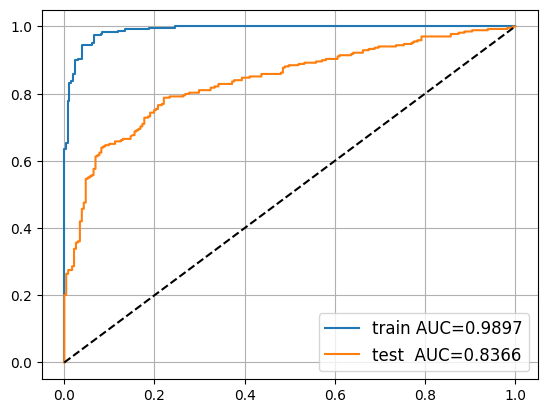

In [81]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. We'll go with the positive one [because reasons](https://www.urbandictionary.com/define.php?term=because%20reasons).

__Your task__ is to compute top-25 words that have the __highest__ ratio of ${p(x_i | y=1)} \over {p(x_i | y=0)}$. Enjoy!

In [92]:
probability_ratio = naive_model.p_x_given_positive / naive_model.p_x_given_negative
indices = np.argpartition(-probability_ratio, 25)[:25]
top_negative_words = [index_to_word[index] for index in indices]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[word_to_index[word]]})")

#0	      heil	(ratio=471.8065185546875)
#1	   college	(ratio=17.11215591430664)
#2	    stupid	(ratio=18.33445167541504)
#3	       ass	(ratio=26.890527725219727)
#4	   fucking	(ratio=31.779714584350586)
#5	      slap	(ratio=44.002681732177734)
#6	      shit	(ratio=44.002681732177734)
#7	      fuck	(ratio=53.78105545043945)
#8	     bitch	(ratio=59.89254379272461)
#9	      fggt	(ratio=97.78373718261719)
#10	      dick	(ratio=187.0113983154297)
#11	 j.delanoy	(ratio=220.01341247558594)
#12	         =	(ratio=17.53995704650879)
#13	      suck	(ratio=314.7414245605469)
#14	    nigger	(ratio=223.6802978515625)
#15	   offfuck	(ratio=441.2491149902344)
#16	    hitler	(ratio=475.47344970703125)
#17	         *	(ratio=17.11215591430664)
#18	   bastard	(ratio=14.667561531066895)
#19	     idiot	(ratio=13.445263862609863)
#20	   asshole	(ratio=15.889857292175293)
#21	       hit	(ratio=14.667561531066895)
#22	         u	(ratio=15.278709411621094)
#23	         @	(ratio=13.445263862609863)
#24	scientific

Now lets try something less prehistoric: __Logistic Regression__. Turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

bow_model = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

clf = GridSearchCV(bow_model, parameters)
clf.fit(X_train_bow, y_train)

bow_model = clf.best_estimator_

Model accuracy: 0.770
Well done!


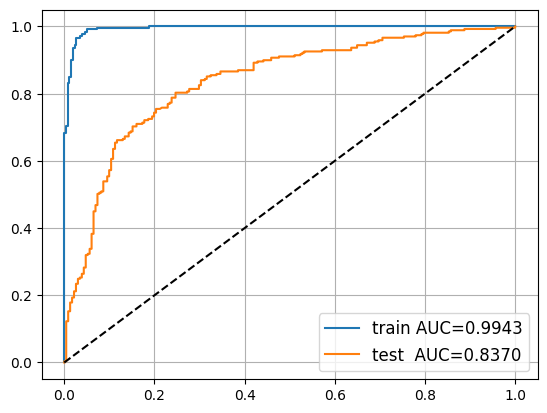

In [108]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy >= 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ \text{feature}_i = \frac{\text{Count}(word_i \in x)}{\text{Total number of words in } x} \times \log\left(\frac{N}{\text{Count}(word_i \in D) + \alpha}\right) $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :) You can still use 'em for debugging though.

In [113]:
k = 10000

bow = Counter()
for text in texts_train:
    bow.update(text.split())

most_common = bow.most_common(k)
word_to_index = {word: idx for idx, (word, _) in enumerate(most_common)}

In [116]:
df = defaultdict(int)

for text in texts_train:
    unique_words = set(text.split())
    for word in unique_words:
        if word in word_to_index:
            df[word] += 1

In [118]:
N = len(texts_train)
alpha = 1.0 
idf = np.zeros(k, dtype='float32')

for word, idx in word_to_index.items():
    idf[idx] = np.log((N) / (df[word] + alpha))

In [119]:
def text_to_tfidf(text):
    vec = np.zeros(k, dtype='float32')
    words = text.split()
    total = len(words)

    tf_counter = Counter()
    for word in words:
        if word in word_to_index:
            tf_counter[word] += 1

    for word, count in tf_counter.items():
        idx = word_to_index[word]
        tf = count / total
        vec[idx] = tf * idf[idx]

    return vec

In [120]:
X_train_tfidf = np.stack([text_to_tfidf(text) for text in texts_train])
X_test_tfidf = np.stack([text_to_tfidf(text) for text in texts_test])

In [131]:
tf_idf_model = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
}

tf_idf_clf = GridSearchCV(tf_idf_model, parameters)
tf_idf_clf.fit(X_train_tfidf, y_train)

tf_idf_model = tf_idf_clf.best_estimator_

Model accuracy: 0.770


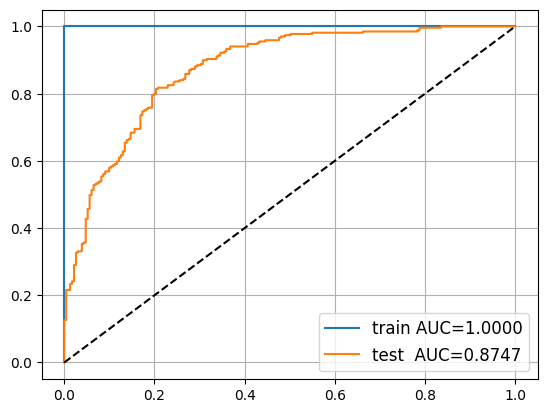

In [133]:
for name, X, y, model in [
    ('train', X_train_tfidf, y_train, tf_idf_model),
    ('test ', X_test_tfidf, y_test, tf_idf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(tf_idf_model.predict(X_test_tfidf) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Solving it better: word vectors

Let's try another approach: instead of counting per-word frequencies, we shall map all words to pre-trained word vectors and average over them to get text features.

This should give us two key advantages: (1) we now have 10^2 features instead of 10^4 and (2) our model can generalize to word that are not in training dataset.

We begin with a standard approach with pre-trained word vectors. However, you may also try
* training embeddings from scratch on relevant (unlabeled) data
* multiplying word vectors by inverse word frequency in dataset (like tf-idf).
* concatenating several embeddings
    * call `gensim.downloader.info()['models'].keys()` to get a list of available models
* clusterizing words by their word-vectors and try bag of cluster_ids

__Note:__ loading pre-trained model may take a while. It's a perfect opportunity to refill your cup of tea/coffee and grab some extra cookies. Or binge-watch some tv series if you're slow on internet connection

In [155]:
import gensim.downloader 
embeddings = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [156]:
def vectorize_sum(comment):
    """
    implement a function that converts preprocessed comment to a sum of token vectors
    """
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment.split():
        if word in embeddings:
            features += embeddings[word]            
    
    return features

assert np.allclose(
    vectorize_sum("who cares anymore . they attack with impunity .")[::70],
    np.array([ 0.0108616 ,  0.0261663 ,  0.13855131, -0.18510573, -0.46380025])
)

In [157]:
X_train_wv = np.stack([vectorize_sum(text) for text in texts_train])
X_test_wv = np.stack([vectorize_sum(text) for text in texts_test])

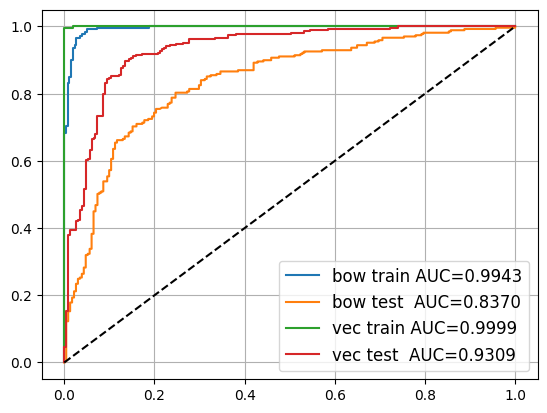

In [158]:
wv_model = LogisticRegression(max_iter=10000).fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

assert roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]) > 0.92, "something's wrong with your features"

In [159]:
print(roc_auc_score(y_test, wv_model.predict_proba(X_test_wv)[:, 1]))

0.9309451391235778


If everything went right, you've just managed to reduce misclassification rate by a factor of two.
This trick is very useful when you're dealing with small datasets. However, if you have hundreds of thousands of samples, there's a whole different range of methods for that. We'll get there in the second part.

## emb * idf

In [187]:
def vectorize_sum_idf(comment):
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment.split():
        if word in embeddings and word in df:
            emb = embeddings[word]
            features += emb * idf[word_to_index[word]]
            
            # total_idf = sum(idf[word_to_index[word]] for word in comment.split() if word_to_index.get(word, 0) > 0)
            # if total_idf > 0:
            #     features /= total_idf
    
    return features

In [188]:
vectorize_sum_idf(texts_train[0]).shape

(300,)

In [189]:
X_train_wv_idf = np.stack([vectorize_sum_idf(text) for text in texts_train])
X_test_wv_idf = np.stack([vectorize_sum_idf(text) for text in texts_test])

0.8983166771270861


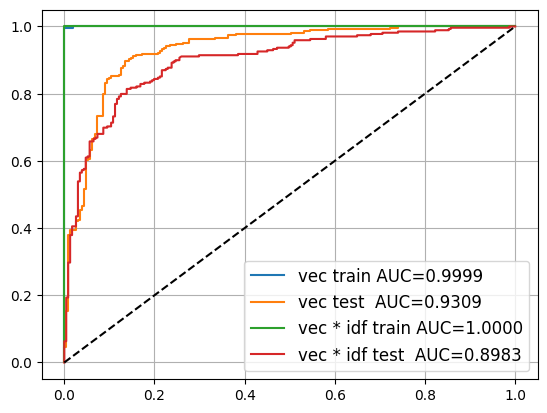

In [190]:
wv_idf_model = LogisticRegression(max_iter=10000).fit(X_train_wv_idf, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model),
    ('vec * idf train', X_train_wv_idf, y_train, wv_idf_model),
    ('vec * idf test ', X_test_wv_idf, y_test, wv_idf_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

print(roc_auc_score(y_test, wv_idf_model.predict_proba(X_test_wv_idf)[:, 1]))

## SIF

The approach proposed in [the paper](https://arxiv.org/abs/1705.02364).

In [214]:
from sklearn.decomposition import PCA


# df - dict of tokens count
total_tokens = sum(df.values())
tokens_freq = {word: cnt / total_tokens for word, cnt in df.items()}

alpha = 0.001
sif_weights = {word: alpha / (alpha + freq) for word, freq in tokens_freq.items()}

def vectorize_sum_sif(comment):
    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')

    for word in comment.split():
        if word in embeddings and word in sif_weights:
            emb = embeddings[word]
            features += emb * sif_weights[word]
            
            # norm_coef = sum(1 for word in comment.split() if word in embeddings)
            # if norm_coef > 0:
            #     features /= norm_coef
    
    return features


pca = PCA(n_components=1)
pca.fit(X_train_wv_sif)

def sif_minus_pca1(X):
    u = pca.components_[0]

    return X - X @ u[:, None] * u

In [215]:
X_train_wv_sif = np.stack([vectorize_sum_sif(text) for text in texts_train])
X_train_wv_sif = sif_minus_pca1(X_train_wv_sif)

X_test_wv_sif = np.stack([vectorize_sum_sif(text) for text in texts_test])
X_test_wv_sif = sif_minus_pca1(X_test_wv_sif)

0.8965142664027423


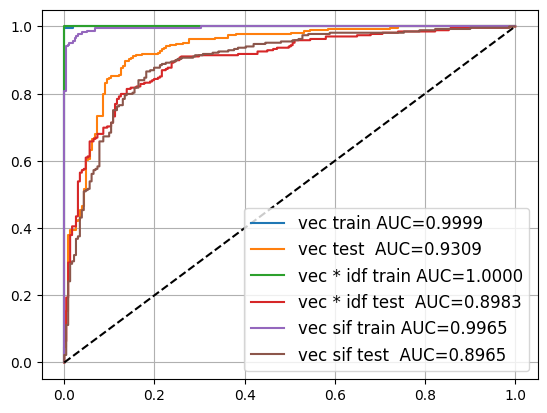

In [216]:
wv_sif_model = LogisticRegression(max_iter=10000).fit(X_train_wv_sif, y_train)

for name, X, y, model in [
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model),
    ('vec * idf train', X_train_wv_idf, y_train, wv_idf_model),
    ('vec * idf test ', X_test_wv_idf, y_test, wv_idf_model),
    ('vec sif train', X_train_wv_sif, y_train, wv_sif_model),
    ('vec sif test ', X_test_wv_sif, y_test, wv_sif_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

print(roc_auc_score(y_test, wv_sif_model.predict_proba(X_test_wv_sif)[:, 1]))

It seems that both approaches (embedding + IDF and embedding + SIF) actually worsen the baseline, where we simply use pre-trained embeddings.  
This is likely because our dataset is very small (only 500 comments in the training set), so any statistics computed from it are noisy and lead to overfitting.   
The pre-trained embeddings, which were trained on a large corpus, perform better.